# CNTK 206:  Part B - Time series prediction with LSTM (IOT Data)

In [part A of this tutorial](CNTK_106A_LSTM_Timeseries_with_Simulated_Data.ipynb) we developed a simple LSTM network to predict future values in a time series. In part B we want to use the model on some real world internet-of-things ([IOT](https://en.wikipedia.org/wiki/Internet_of_things)) data. As an example we want to predict the daily output of a solar panel base on the initial readings of the day. 

[Solar power forecasting](https://en.wikipedia.org/wiki/Solar_power_forecasting) is a challenging and important problem. The solar energy generation forecasting problem is closely linked to the problem of weather variables forecasting. Indeed, this problem is usually split into two parts, on one hand focusing on the forecasting of solar PV or any other meteorological variable and on the other hand estimating the amount of energy that a concrete power plant will produce with the estimated meteorological resource. In general, the way to deal with this difficult problem is usually related to the spatial and temporal scales we are interested in. This tutorial focusses on a simplified forecasting model using previously generated data from solar panel to predict the future. 

**Goal**

Using historic daily production of a solar panel, we want to predict the total power production of the solar panel array for a future day. We will be using the LSTM based time series prediction model developed in part A to predict the daily output of a solar panel based on the initial readings of a the day. 

![rooftop-solar](https://www.cntk.ai/jup/rooftop-solar-power.jpg)

We train the model with historical data of the solar panel. In our example we want to predict the total power production of the solar panel array for the day starting with the initial readings of the day. We start predicting after the first 2 readings and adjust the prediction with each new reading.

In this tutorial, we will use the LSTM model introduced in the CNTK 106A. This tutorial has the following sub-sections:
- Setup
- Data generation
- LSTM network modeling
- Model training and evaluation

For more details on how LSTMs work, see [this excellent post](http://colah.github.io/posts/2015-08-Understanding-LSTMs).

# Setup
We need a few imports and constants throughout the tutorial that we define here.

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import time

import cntk as C
import cntk.axis
from cntk.blocks import Input
from cntk.layers import Dense, Dropout, Recurrence 

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

%matplotlib inline

In [2]:
# to make things reproduceable, seed random
np.random.seed(0)

### Select the notebook runtime environment devices / settings

Set the device to cpu / gpu for the test environment. If you have both CPU and GPU on your machine, you can optionally switch the devices. By default we choose the best available device.

In [3]:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.set_default_device(C.device.cpu())
    else:
        C.device.set_default_device(C.device.gpu(0))

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

For *Fast mode* we train the model for 100 epochs and results have low accuracy but is good enough for development. The model yields good accuracy after 1000-2000 epochs.

In [4]:
isFast = True

# we need around 2000 epochs to see good accuracy. For testing 100 epochs will do.
EPOCHS = 100 if isFast else 2000

# Data generation

Our solar panel, emits two measures at every 30 min interval:
- `solar.current` is the current production in Watt
- `solar.total` is the total produced for the day so far in Watt/hour

Our prediction approach involves starting with the first 2 initial readings of the day. Based on these readings we start predicting and adjust the prediction with each new reading. The training data we are going to use comes as a csv file and has the following format:

>```
time,solar.current,solar.total
7am,6.3,1.7
7:30am,44.3,11.4
...
>```

The training dataset we use contains data captured for 3 years and can be found [here](https://guschmueds.blob.core.windows.net/datasets/solar.csv). 
The dataset is not pre-processed: it is raw data and contains smaller gabs and errors (like a panel failed to report).

## Pre-processing
Most of the code in this example is related to data preparation. Thankfully the pandas library make this easy.

`generate_solar_data()` function performs the following tasks:
- read raw data into a pandas dataframe, 
- normalize the data, 
- groups by day and 
- append the columns "solar.current.max" and "solar.total.max", and
- generates the sequences for each day.

*Sequence generation*: All sequences are concatenated into a single list of sequences. There is *no more notion of timestamp* in our train input and **only** the sequences matter.

**Note** if we have less than 8 datapoints for a day we skip over the day assuming something is missing in the raw data. If we get more than 14 data points in a day we truncate the readings.

## Training / Testing / Validation data preparation
The raw data is sorted by time and we should randomize it before splitting into training, validation and test datasets but this would make it impractical to visualize results in the tutorial. Hence, we split the dataset in the following manner: pick in sequence, 8 values for training, 1 for validation and 1 for test until there is no more data. This will spread training, validation and test datasets across the full timeline while preserving time order.


In [5]:
def generate_solar_data(input_url, time_steps, normalize=1, val_size=0.1, test_size=0.1):
    """
    generate sequences to feed to rnn based on data frame with solar panel data
    the csv has has the format: time ,solar.current, solar.total
     (solar.current is the current output in Watt, solar.total is the total production
      for the day so far in Watt hours)
    """
    # try to find the data file local. If it doesn't exists download it.
    cache_path = os.path.join("data", "iot")
    cache_file = os.path.join(cache_path, "solar.csv")
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    if not os.path.exists(cache_file):
        urlretrieve(input_url, cache_file)
        print("downloaded data successfully from ", input_url)
    else:
        print("using cache for ", input_url)
    
    df = pd.read_csv(cache_file, index_col="time", parse_dates=['time'])
    
    df["date"] = df.index.date
    
    # normalize data
    df['solar.current'] /= normalize
    df['solar.total'] /= normalize
    
    # group by day, find the max for a day and add a new column .max
    grouped = df.groupby(df.index.date).max()
    grouped.columns = ["solar.current.max", "solar.total.max", "date"]

    # merge continuous readings and daily max values into a single frame
    df_merged = pd.merge(df, grouped, right_index=True, on="date")
    df_merged = df_merged[["solar.current", "solar.total",
                           "solar.current.max", "solar.total.max"]]
    # we group by day so we can process a day at a time.
    grouped = df_merged.groupby(df_merged.index.date)
    per_day = []
    for _, group in grouped:
        per_day.append(group)

    # split the dataset into train, validatation and test sets on day boundaries
    val_size = int(len(per_day) * val_size)
    test_size = int(len(per_day) * test_size)
    next_val = 0
    next_test = 0

    result_x = {"train": [], "val": [], "test": []}
    result_y = {"train": [], "val": [], "test": []}    

    # generate sequences a day at a time
    for i, day in enumerate(per_day):
        # if we have less than 8 datapoints for a day we skip over the
        # day assuming something is missing in the raw data
        total = day["solar.total"].values
        if len(total) < 8:
            continue
        if i >= next_val:
            current_set = "val"
            next_val = i + int(len(per_day) / val_size)
        elif i >= next_test:
            current_set = "test"
            next_test = i + int(len(per_day) / test_size)
        else:
            current_set = "train"
        max_total_for_day = np.array(day["solar.total.max"].values[0])
        for j in range(2, len(total)):
            result_x[current_set].append(total[0:j])
            result_y[current_set].append([max_total_for_day])
            if j >= time_steps:
                break
    # make result_y a numpy array
    for ds in ["train", "val", "test"]:
        result_y[ds] = np.array(result_y[ds])
    return result_x, result_y

## Data caching
For routine testing we would like to cache the data locally when available. If it is not available from the cache locations we shall download.

In [6]:
# there are 14 lstm cells, 1 for each possible reading we get per day
TIMESTEPS = 14

# 20000 is the maximum total output in our dataset. We normalize all values with 
# this so our inputs are between 0.0 and 1.0 range.
NORMALIZE = 20000

X, Y = generate_solar_data("https://www.cntk.ai/jup/dat/solar.csv", 
                           TIMESTEPS, normalize=NORMALIZE)

using cache for  https://www.cntk.ai/jup/dat/solar.csv


### Utility for data fetching

`next_batch()` yields the next batch for training. We use variable size sequences supported by CNTK and batches are a list of numpy arrays where the numpy arrays have variable length. 

A standard practice is to shuffle batches with each epoch. We don't do this here because we want to be able to graph the data that is easily interpretable.

In [7]:
# process batches of 10 days
BATCH_SIZE = TIMESTEPS * 10

def next_batch(x, y, ds):
    """get the next batch for training"""

    def as_batch(data, start, count):
        return data[start:start + count]

    for i in range(0, len(x[ds]), BATCH_SIZE):
        yield as_batch(X[ds], i, BATCH_SIZE), as_batch(Y[ds], i, BATCH_SIZE)

### Understand the data format
You can now see the sequence we are going to feed to the LSTM. Note if we have less than 8 datapoints for a day we skip over the day assuming something is missing in the raw data. If we get more than 14 data points in a day we truncate the readings.

In [8]:
X['train'][0:3]

[array([ 0.       ,  0.0006985]),
 array([ 0.       ,  0.0006985,  0.0033175]),
 array([ 0.       ,  0.0006985,  0.0033175,  0.010375 ])]

In [9]:
Y['train'][0:3]

array([[ 0.239],
       [ 0.239],
       [ 0.239]])

## LSTM network setup

Corresponding  to the maximum possible 14 data points in the input sequence, we model our network with 14 LSTM cells, 1 cell for each data point we take during the day. Since the input sequences can be between 8 and 14 data points per sequence, we take the advantage of CNTK support for variable sequences as input to a LSTM so we can feed our sequences as-is with no additional need for padding.

The output of the neural network is the total output for the day and each sequence for a given day has the same total output.

For example:
```
1.7,11.4 -> 10300
1.7,11.4,67.5 -> 10300
1.7,11.4,67.5,250.5 ... -> 10300
1.7,11.4,67.5,250.5,573.5 -> 10300
```

The outputs from the LSTMs are feed into a dense layer and we randomly dropout 20% of the values to not overfit the model to the training set. The output of the dense layer becomes the prediction our model generates.

Notice: We lost the timestamp altogether; in our model only the sequences of readings matter. 

Our LSTM model has the following design:
![lstm](https://guschmueds.blob.core.windows.net/datasets/2.png)

The network model is an exact translation of the network diagram above.

In [10]:
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.LSTM(TIMESTEPS))(x)
        m = C.sequence.last(m)
        m = C.layers.Dropout(0.2)(m)
        m = cntk.layers.Dense(1)(m)
        return m

# Training
Before we can start training we need to bind our input variables for the model and define what optimizer we want to use. For this example we choose the `adam` optimizer. We choose `squared_error` as our loss function.

In [11]:
# input sequences
x = C.blocks.Input(1)

# create the model
z = create_model(x)

# expected output (label), also the dynamic axes of the model output
# is specified as the model of the label input
l = C.blocks.Input(1, dynamic_axes=z.dynamic_axes, name="y")

# the learning rate
learning_rate = 0.005
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss function
loss = C.ops.squared_error(z, l)

# use squared error to determine error for now
error = C.ops.squared_error(z, l)

# use adam optimizer
momentum_time_constant = C.learner.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.learner.adam_sgd(z.parameters, 
                             lr = lr_schedule, 
                             momentum = momentum_time_constant)
trainer = C.Trainer(z, (loss, error), [learner])

Time to start training.

In [12]:
# training
loss_summary = []

start = time.time()
for epoch in range(0, EPOCHS):
    for x_batch, l_batch in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x_batch, l: l_batch})
        
    if epoch % (EPOCHS / 10) == 0:
        training_loss = C.utils.get_train_loss(trainer)
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.4f}".format(epoch, training_loss))

print("Training took {:.1f} sec".format(time.time() - start))

epoch: 0, loss: 0.0966
epoch: 10, loss: 0.0305
epoch: 20, loss: 0.0208
epoch: 30, loss: 0.0096
epoch: 40, loss: 0.0088
epoch: 50, loss: 0.0072
epoch: 60, loss: 0.0071
epoch: 70, loss: 0.0075
epoch: 80, loss: 0.0082
epoch: 90, loss: 0.0082
Training took 100.5 sec


A look how the loss function shows how the model is converging:

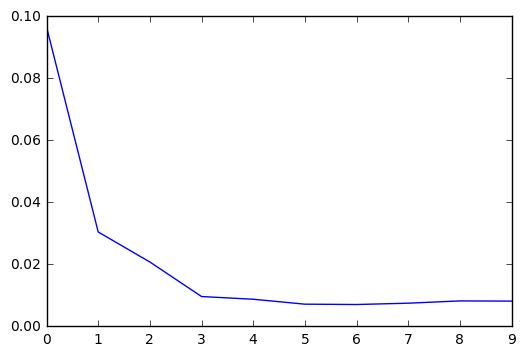

In [13]:
plt.plot(loss_summary, label='training loss');

Let us validate the training validation and test dataset. We use mean squared error as measure which might be a little simplistic. A method that would define a ratio how many predictions have been inside a given tolerance would make a better measure.

In [14]:
# validate
def get_mse(X,Y,labeltxt):
    result = 0.0
    for x1, y1 in next_batch(X, Y, labeltxt):
        eval_error = trainer.test_minibatch({x : x1, l : y1})
        result += eval_error
    return result/len(X[labeltxt])

In [15]:
# Print the train and validation errors
for labeltxt in ["train", "val"]:
    print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for train: 0.000079
mse for val: 0.000076


In [16]:
# Print the test error
labeltxt = "test"
print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for test: 0.000076


# Visualize the prediction

Our model has been trained well, given the train, validation and test errors are in the same ball park. Predicted time series data renders well with visualization of the results. Let us take our newly created model, make predictions and plot them against the actual readings.

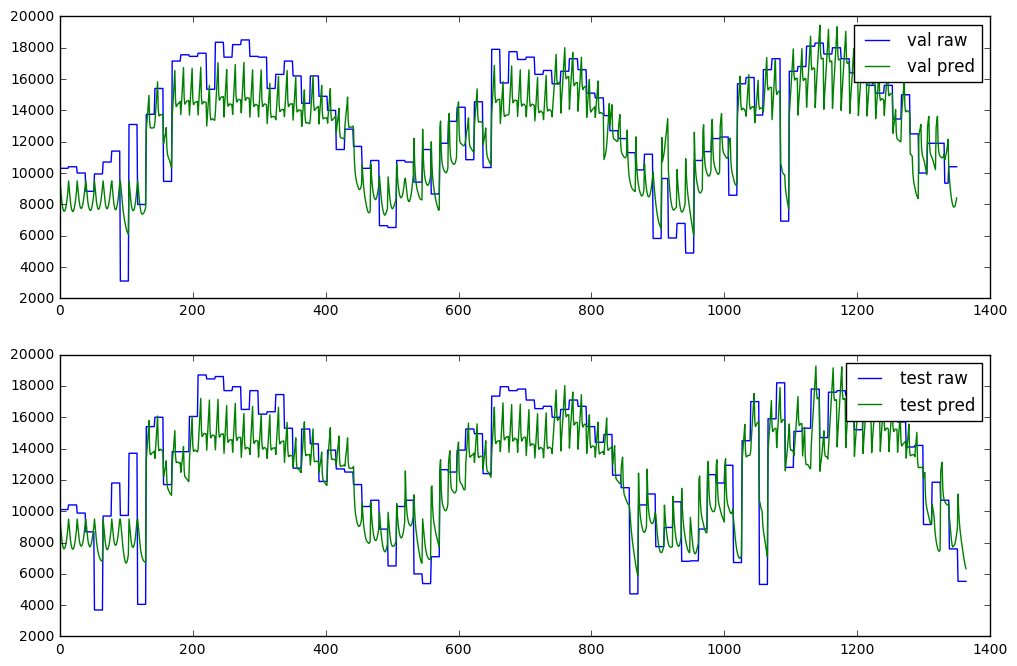

In [17]:
# predict
f, a = plt.subplots(2, 1, figsize=(12, 8))
for j, ds in enumerate(["val", "test"]):
    results = []
    for x_batch, _ in next_batch(X, Y, ds):
        pred = z.eval({x: x_batch})
        results.extend(pred[:, 0])
    # because we normalized the input data we need to multiply the prediction
    # with SCALER to get the real values.
    a[j].plot((Y[ds] * NORMALIZE).flatten(), label=ds + ' raw');
    a[j].plot(np.array(results) * NORMALIZE, label=ds + ' pred');
    a[j].legend();

If we let the model train for 2000 epochs the predictions are close to the actual data and follow the right pattern.

# Suggested activity

So what we do with this model? A practical application would be to generate alerts if the actual output is not in line with the prediction, for example if one of the panels is failing. The solar array that goes with our dataset has 16 panels. If we'd want to detect failure without generating false alerts, the accuracy of our prediction would need to be at least 1 - 1/16, around 94%. Our model is close to this but would most likely generate occasional false alerts.

- Improve the model by training for more epochs.
- Further preprocess the training set to smooth-out missing values
- Try out more complex networks.

However, in our experience with time series data one can achieve significant accuracy improvement comes from higher resolution training data, for example reading a data point every 5 minutes instead of every 30 minutes.

We hope this tutorial gets you started on time series prediction with neural networks.